# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [125]:
# import sys
# sys.path.append('C:\Proj\machineLearning-algorithm\DeepLearning\cs231n\HomeWorks\\assignment1')
import pdb

In [80]:
# Run some setup code for this notebook.
import random

import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
% matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# 在文件修改的时候对应更新
% load_ext autoreload
% autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print ('Training data shape: ', X_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

('Training data shape: ', (50000L, 32L, 32L, 3L))
('Training labels shape: ', (50000L,))
('Test data shape: ', (10000L, 32L, 32L, 3L))
('Test labels shape: ', (10000L,))


In [82]:
x = [[0,2],[2,3]]
np.flatnonzero(x)

array([1, 2, 3], dtype=int64)

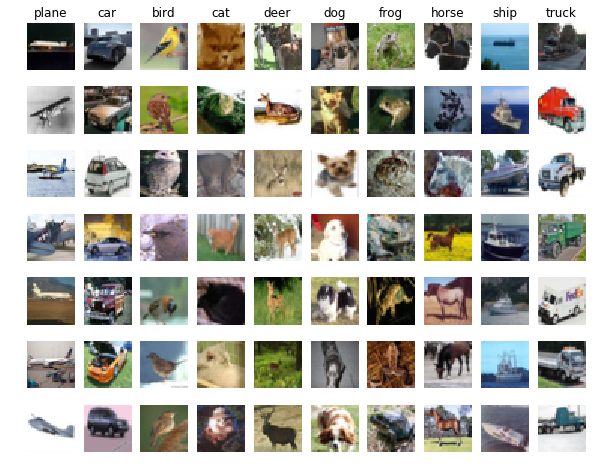

In [83]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
# 一共10个labels
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)

#打印每个类中的七张图
samples_per_class = 7
# 对应enumerate() 返回为index和label 类似：
# [(0, 'bread'), (1, 'milk'), (2, 'butter')] [(10, 'bread'), (11, 'milk'), (12, 'butter')]
for y, cls in enumerate(classes):
#     flatnonzero(a) : Return indices that are non-zero in the flattened version(扁平化) of a, 输入一个矩阵，
#     返回扁平化的不为0的index的位置
    
    
#   y 代表不同的label值, 这里选择label值是y 的数据的index
    idxs = np.flatnonzero(y_train == y)
#   有了对应label的index，随机选 7 个
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
#         i:横坐标，plt_idx纵坐标  编号
        plt_idx = i * 10 + y + 1 
#         print 'i -> _%d' % (i, )
#         print ' plt_idx-> _%d' % (plt_idx)
#     matplotlib下, 一个 Figure 对象可以包含多个子图(Axes), 可以使用 subplot() 快速绘制, 其调用形式如下 :
#     subplot(numRows, numCols, plotNum)
        plt.subplot(samples_per_class, num_classes, plt_idx)
#     绘图颜色 cmap: 颜色图谱（colormap), 默认绘制为RGB(A)颜色空间。例如;
        plt.imshow(X_train[idx].astype('uint8'),cmap='Greens')
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [84]:
# Subsample the data for more efficient code execution in this exercise
# 二次抽样
# 取500个样本做为训练样本
num_training = 500
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

print X_train.shape
print y_train.shape

# 取50个样本做为test样本
num_test = 50
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

(500L, 32L, 32L, 3L)
(500L,)


In [85]:
# Reshape the image data into rows
# reshape是一种函数，函数可以重新调整矩阵的行数、列数、维数。
# np.reshape(X_train, (500, -1))->(500, 3072)
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print X_train.shape, X_test.shape

(500L, 3072L) (50L, 3072L)


### KNN comming!

In [86]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [87]:
x = np.array([[1], [2], [3]])
y = np.array([4, 5, 6])
b = np.broadcast(x, y)
print b

In [88]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
# dists[i,j]表示第i个test数据和第j个train数据的L2距离的平方
# 然后选择最近的k个距离 多数投票 就可以得出这50个test数据对应的预测label值了
# dists = classifier.compute_distances_two_loops(X_test)
# dists2 = classifier.compute_distances_one_loop(X_test)
# dists3 = classifier.compute_distances_no_loops(X_test)

dists = classifier.compute_distances_no_loops(X_test)

# print dists.shape
# print dists[25]

(50L, 3072L)
(500L, 3072L)


In [89]:
print dists

[[14469834. 17729119. 30294615. ... 24826554. 23691410. 15537354.]
 [40155461. 27775852. 16326740. ... 15703879. 21828107. 27218399.]
 [27298944. 18067965. 14242667. ... 16335112. 21952986. 18182066.]
 ...
 [14871993. 18418826. 27172202. ... 24321723. 23491483. 12071979.]
 [ 8197496. 15872989. 31683863. ... 24223316. 19976802. 15083778.]
 [ 8496154. 18611911. 27878341. ... 28963902. 23387606. 12061950.]]


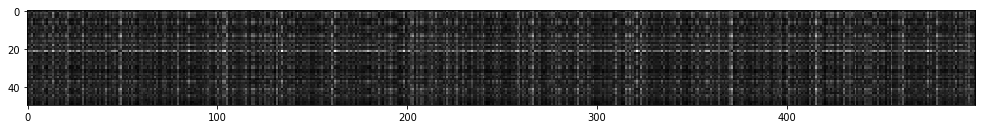

In [90]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
# If interpolation is 'none', then no interpolation is performed on the Agg,
# ps and pdf backends. Other backends will fall back to 'nearest'.
# print dists[28]
plt.figure(figsize=(17,5))
# fig.savefig('test2png.png', dpi=100)
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?  
- What causes the columns?

**Your Answer**: *fill this in.*
- What in the data is the cause behind the distinctly bright rows?  有些test数据的图和其他所有的train的图的距离都很远，有可能test的这个图的类 不在train的图中
- What causes the columns? train的图中某一些图的label 不在test图中


In [95]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=4)
print y_test_pred
print y_test
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

[6. 8. 8. 8. 6. 6. 6. 6. 4. 8. 8. 9. 6. 7. 8. 8. 5. 4. 9. 6. 8. 3. 4. 6.
 8. 8. 9. 8. 5. 6. 4. 5. 4. 7. 8. 6. 6. 9. 8. 5. 8. 4. 6. 6. 8. 8. 6. 4.
 6. 6.]
[3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6 6 5 4 5 9 2 4
 1 9 5 4 6 5 6 0 9 3 9 7 6]
Got 17 / 50 correct => accuracy: 0.340000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [96]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)
print y_test_pred
print y_test

Got 14 / 50 correct => accuracy: 0.280000
[6. 8. 9. 8. 6. 6. 6. 7. 4. 8. 8. 9. 6. 7. 8. 8. 5. 4. 9. 6. 8. 3. 4. 6.
 8. 8. 9. 8. 5. 6. 4. 5. 4. 7. 8. 6. 6. 9. 8. 8. 8. 4. 6. 6. 8. 8. 6. 6.
 6. 6.]
[3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6 6 5 4 5 9 2 4
 1 9 5 4 6 5 6 0 9 3 9 7 6]


You should expect to see a slightly better performance than with `k = 1`.

In [97]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

Difference was: 0.000000
Good! The distance matrices are the same


In [124]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

数据格式：
50
(400L, 3072L)


ValueError: operands could not be broadcast together with shapes (50,500) (50,400) 

In [99]:
# Let's compare how fast the implementations are
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print 'Two loop version took %f seconds' % two_loop_time

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print 'One loop version took %f seconds' % one_loop_time

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print 'No loop version took %f seconds' % no_loop_time

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 4.714000 seconds
One loop version took 0.676000 seconds
(50L, 3072L)
(500L, 3072L)
No loop version took 0.934000 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [133]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################

X_train_folds = np.array_split(X_train,num_folds,axis=0)
y_train_folds = np.array_split(y_train,num_folds,axis=0)


################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

# k = 1, accuracy = 0.240000
# k = 1, accuracy = 0.230000
# k = 1, accuracy = 0.240000
# k = 1, accuracy = 0.250000
# k = 1, accuracy = 0.290000
# k = 3, accuracy = 0.170000
# k = 3, accuracy = 0.230000

################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for k in k_choices:
    
    k_to_accuracies[k] = []
    for val_idx in range(num_folds):
        
        X_val = X_train_folds[val_idx]
        y_val = y_train_folds[val_idx]
        
        X_tra = X_train_folds[:val_idx] + X_train_folds[val_idx + 1:]
        X_tra = np.reshape(X_tra, (X_train.shape[0] - X_val.shape[0], -1))
        y_tra = y_train_folds[:val_idx] + y_train_folds[val_idx + 1:]
        y_tra = np.reshape(y_tra, (X_train.shape[0] - X_val.shape[0],))
        
        classifier.train(X_tra, y_tra)
        #预测
        y_val_pre = classifier.predict(X_val, k, 0)
        
        right_arr = y_val_pre == y_val
        accuracy = float(np.sum(right_arr)) / y_val.shape[0]
        k_to_accuracies[k].append(accuracy)
        
    
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print 'k = %d, accuracy = %f' % (k, accuracy)

[array([[ 59.,  62.,  63., ..., 123.,  92.,  72.],
       [154., 177., 187., ..., 143., 133., 144.],
       [255., 255., 255., ...,  80.,  86.,  84.],
       ...,
       [ 33.,  44.,  27., ...,  71.,  90.,  40.],
       [ 90.,  77.,  59., ..., 102.,  96.,  80.],
       [ 62.,  64.,  44., ..., 169., 156., 160.]]), array([[213., 229., 242., ..., 228., 228., 226.],
       [155., 156., 158., ...,  81.,  89.,  85.],
       [150., 183., 202., ..., 154., 130.,  94.],
       ...,
       [ 66.,  61.,  56., ..., 102.,  96.,  87.],
       [  0.,   0.,   0., ...,  78.,  65.,  53.],
       [167., 178., 196., ...,  96., 100., 111.]]), array([[105., 155., 204., ...,  84., 160., 196.],
       [ 48.,  30.,  35., ...,  45.,  36.,  30.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [ 94., 110., 136., ...,  43.,  50.,  70.],
       [ 30.,  17.,  20., ...,  71.,  60.,  65.],
       [112., 107.,  60., ..., 125., 124.,  73.]]), array([[117., 123.,  77., ...,  99., 122.,  42.],
       

BdbQuit: 

[1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
{1: [0.24, 0.23, 0.24, 0.25, 0.29], 3: [0.18, 0.24, 0.32, 0.22, 0.2], 100: [0.12, 0.11, 0.13, 0.1, 0.1], 5: [0.19, 0.19, 0.3, 0.17, 0.16], 8: [0.15, 0.19, 0.29, 0.13, 0.22], 10: [0.16, 0.19, 0.27, 0.12, 0.22], 12: [0.16, 0.18, 0.25, 0.12, 0.24], 15: [0.2, 0.18, 0.25, 0.11, 0.26], 50: [0.14, 0.1, 0.14, 0.1, 0.12], 20: [0.22, 0.13, 0.22, 0.09, 0.23]}


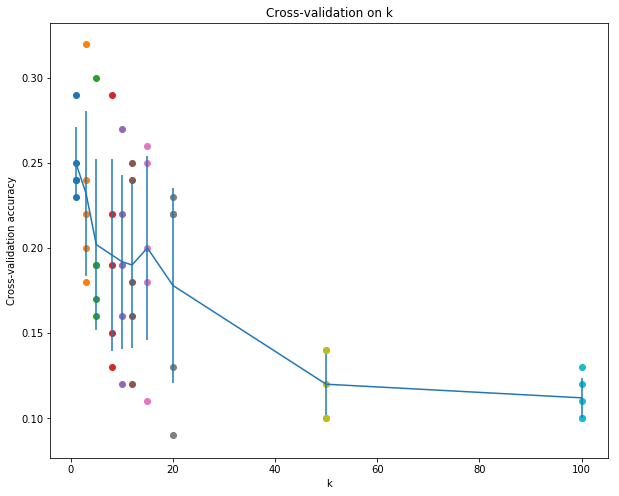

In [123]:
# plot the raw observations
print k_choices
print k_to_accuracies
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [83]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 3

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 15 / 50 correct => accuracy: 0.300000
